In [172]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import math
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

### Importing the Dataset

In [177]:
df = pd.read_csv("UCI_Credit_Card.csv")
df=df.drop(columns='ID')
df = df.rename(columns = {'default.payment.next.month':'default_class'})
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_class
0,20000.0,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,120000.0,2,2,2,26,-1,2,0,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,90000.0,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,50000.0,2,2,1,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,50000.0,1,2,1,57,-1,0,-1,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


### Data Exploration and Data Cleaning

In [183]:
print(pd.DataFrame(df['default_class'].value_counts()))
print("\n",pd.DataFrame(df['SEX'].value_counts()))
print("\n",pd.DataFrame(df['EDUCATION'].value_counts()))
print("\n",pd.DataFrame(df['MARRIAGE'].value_counts()))

   default_class
0          23364
1           6636

      SEX
2  18112
1  11888

    EDUCATION
2      14030
1      10585
3       4917
5        280
4        123
6         51
0         14

    MARRIAGE
2     15964
1     13659
3       323
0        54


### Default Class type = 1 is only 22% of the entire dataset. It is a highly unbalanced dataset.

#### Education categories 4, 5, 6, 0 can be grouped under 'Other' category

In [133]:
df.loc[(df['EDUCATION'] == 5) | (df['EDUCATION'] == 6) | (df['EDUCATION'] == 0),'EDUCATION'] = 4
pd.DataFrame(df['EDUCATION'].value_counts())

,EDUCATION
2,14030
1,10585
3,4917
4,468


#### Marriage categories 3, 0 can be grouped under 'Other' category

In [135]:
df.loc[df.MARRIAGE == 0, 'MARRIAGE'] = 3
pd.DataFrame(df['MARRIAGE'].value_counts())

,MARRIAGE
2,15964
1,13659
3,377


### Dummy Variables creation for categorical variables

In [185]:
df = pd.get_dummies(df, columns=['SEX', 'EDUCATION','MARRIAGE'])

### Train Test Split

In [187]:
x=df.loc[:,df.columns != 'default_class']
y=df['default_class']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3,random_state=1)

### Upsampling the Default Class 1

In [190]:
xy_train = pd.concat([X_train, y_train], axis=1)
not_default = xy_train[xy_train['default_class']==0]
default = xy_train[xy_train['default_class']==1]

# upsample minority
default_upsampled_df = resample(default, replace=True, n_samples=len(not_default), random_state=7) 
upsampled_df = pd.concat([not_default, default_upsampled_df])
pd.DataFrame(upsampled_df['default_class'].value_counts())

,default_class
1,16364
0,16364


In [191]:
X_train_upsampled = upsampled_df.loc[:,upsampled_df.columns != 'default_class']
y_train_upsampled = upsampled_df['default_class']


### Under sampling the Default Class 0

In [192]:
xy_train = pd.concat([X_train, y_train], axis=1)
not_default = xy_train[xy_train['default_class']==0]
default = xy_train[xy_train['default_class']==1]

default_undersampled_df = resample(not_default, replace=True, n_samples=7417, random_state=7) 
undersampled_df = pd.concat([default, default_undersampled_df])
pd.DataFrame(undersampled_df['default_class'].value_counts())

,default_class
0,7417
1,4636


In [193]:
X_train_undersampled = undersampled_df.loc[:,undersampled_df.columns != 'default_class']
y_train_undersampled = undersampled_df['default_class']
X_train_undersampled.head()

,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3
8447,70000.0,26,0,0,0,0,0,0,23409.0,23174.0,...,0,1,0,0,0,0,0,0,1,0
4535,230000.0,37,1,-2,-2,-2,-2,-2,0.0,0.0,...,0,1,0,0,0,0,0,0,1,0
27198,30000.0,35,1,-1,-1,2,0,0,0.0,26232.0,...,0,1,0,0,0,0,0,1,0,0
15632,90000.0,25,1,-1,-1,-1,-1,2,0.0,840.0,...,0,1,0,0,0,0,0,0,1,0
17697,60000.0,41,2,0,0,2,0,0,56483.0,55643.0,...,0,1,0,0,0,0,0,1,0,0


### Decision Trees

### Hyperparameter tuning to find optimal value for max_features and min_samples_split

In [194]:
decision_tree_df=pd.DataFrame()
min_samples_split = [2,4,6,8,10,12,14]
max_features = [0.2,0.4,0.6,0.8,1]
for min_split in min_samples_split:
    for features in max_features:
        clf = DecisionTreeClassifier(criterion='entropy',max_depth=15,min_samples_split=min_split,max_features=features,
                                    class_weight = 'balanced',random_state = 3)
        scores = cross_val_score(clf, X_train_upsampled, y_train_upsampled, cv=5,scoring= 'f1')
        values  =  [min_split,features,scores.mean()]
        values = pd.DataFrame(values).T
        decision_tree_df = pd.concat([decision_tree_df,values])
        
decision_tree_df.columns=['Minimum Samples Split','Max Features','F1 Score']     

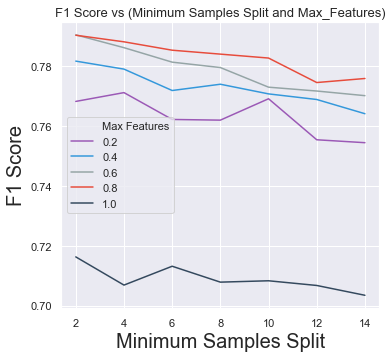

In [202]:
import seaborn as sns
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c","#34495e"]
sns.set(rc={'figure.figsize':(5.7,5.27)})
sns.lineplot(data=decision_tree_df, x='Minimum Samples Split', y='F1 Score',hue='Max Features',palette=flatui)
plt.xlabel("Minimum Samples Split",fontsize=20)
plt.ylabel("F1 Score",fontsize=20)
plt.title("F1 Score vs (Minimum Samples Split and Max_Features)",fontsize=13)
plt.show()

#### Optimal Minimum_samples_Split = 2 or 4 , Optimal Max_Features = 0.8

### Learning Curves with Training sizes

In [272]:
train_sizes, train_scores, valid_scores = learning_curve(DecisionTreeClassifier(criterion='entropy',
                            max_depth=10,max_features=0.8,min_samples_split=2,class_weight = 'balanced',random_state = 3), 
    X_train_upsampled, y_train_upsampled,train_sizes=[0.2,0.4,0.6,0.8,1],cv=5,shuffle=True,random_state=5,scoring='f1')

train_mean = train_scores.mean(axis=1)
valid_mean = valid_scores.mean(axis=1)

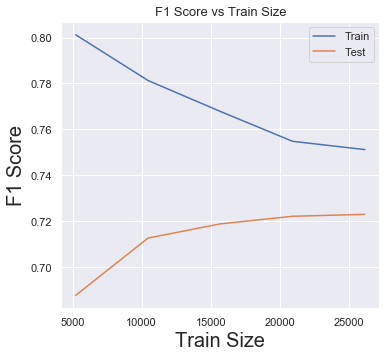

In [273]:
plt.plot(train_sizes, train_mean, label = 'Training F1 Score')
plt.plot(train_sizes, valid_mean, label = 'Validation F1 Score')
plt.xlabel("Train Size",fontsize=20)
plt.ylabel("F1 Score",fontsize=20)
plt.legend(['Train','Test'])
plt.title("F1 Score vs Train Size",fontsize=13)
plt.show()
plt.show()

### Experimentation with pruning

In [274]:
f1_score_dt=dict()
for depth in range(1,15):
    clf = DecisionTreeClassifier(criterion='entropy',max_depth=depth,max_features=0.8,min_samples_split=4,
                                 class_weight = 'balanced',random_state=3)  
    clf.fit(X_train_upsampled,y_train_upsampled)   ### Model fitting
    pred_train = clf.predict(X_train_upsampled)  ### Training set Prediction
    pred_test = clf.predict(X_test)    ### Testing set Prediction
    
    f1_score_dt[depth]=[f1_score(y_train_upsampled, pred_train).round(3),f1_score(y_test, pred_test).round(4)]
    
f1_score_dt_df = pd.DataFrame(f1_score_dt,index=['Train','Test']).T

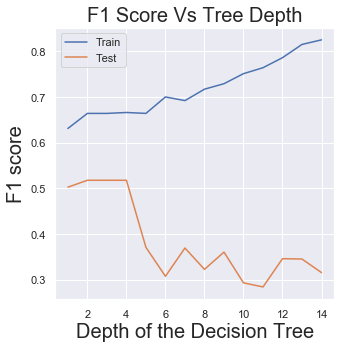

In [275]:
plt.figure(figsize=(5,5))
plt.plot(f1_score_dt_df)
plt.xlabel('Depth of the Decision Tree',fontsize=20)
plt.ylabel('F1 score',fontsize=20)
plt.legend(['Train','Test'])
plt.title('F1 Score Vs Tree Depth',fontsize=20)
plt.show()


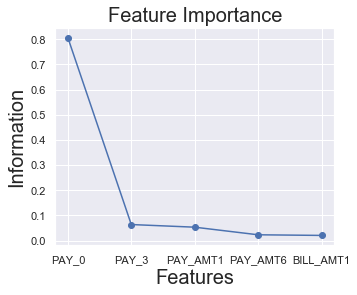

In [277]:
clf = DecisionTreeClassifier(criterion='entropy',max_depth=4,max_features=0.8,
                             class_weight = 'balanced',min_samples_split=4,random_state=3)  ###Criteria: Entropy
clf.fit(X_train_upsampled,y_train_upsampled)
best_features=dict(zip(X_train_upsampled.columns, clf.feature_importances_.round(4)))
best_features=pd.DataFrame(best_features,index=['Importance']).T
plt.figure(figsize=(5,4))
plt.plot(best_features.sort_values(by = 'Importance',ascending=False)[:5],marker='o')
plt.xlabel('Features',fontsize=20)
plt.ylabel('Information',fontsize=20)
plt.title("Feature Importance",fontsize=20)
plt.show()

### Test Dataset Predictions

In [278]:
clf = DecisionTreeClassifier(criterion='entropy',max_depth=4,max_features=0.8,
                             min_samples_split=2,class_weight = 'balanced',random_state=3)  
clf.fit(X_train_upsampled,y_train_upsampled)   ### Model fitting
pred_train = clf.predict(X_train_upsampled)  ### Training set Prediction
pred_test = clf.predict(X_test)    ### Testing set Prediction
print(classification_report(y_test,pred_test))
pd.DataFrame(confusion_matrix(y_test,pred_test),index=['Actual 0','Actual 1'],columns=['Predicted 0','Predicted 1'])

              precision    recall  f1-score   support

           0       0.87      0.82      0.84      7000
           1       0.47      0.57      0.52      2000

    accuracy                           0.76      9000
   macro avg       0.67      0.69      0.68      9000
weighted avg       0.78      0.76      0.77      9000



,Predicted 0,Predicted 1
Actual 0,5721,1279
Actual 1,855,1145


#### The performance on the test F1 score is not improving with increasing depth. But the performances looks good on training set. This is because the training dataset is balanced and the test set is highly unbalanced

### Boosting using Adaboost Algorithm

In [227]:
boosting_df=pd.DataFrame()
learners_values = [5,50,100,200]
for learners in learners_values:
        estimator = AdaBoostClassifier(DecisionTreeClassifier(criterion='entropy',max_depth=4,max_features=0.8,
                             min_samples_split=2,class_weight = 'balanced',random_state=3),n_estimators=learners)
        scores = cross_val_score(estimator, X_train_upsampled, y_train_upsampled, cv=5,scoring='f1')
        values  =  [learners,scores.mean()]
        values = pd.DataFrame(values).T
        boosting_df = pd.concat([boosting_df,values])
        
boosting_df.columns=['Learners','F1_Score']  
boosting_df = boosting_df.reset_index()

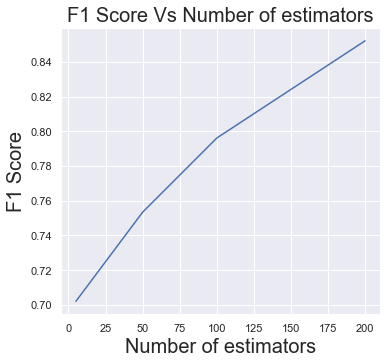

In [229]:
sns.lineplot(data=boosting_df, x='Learners', y='F1_Score')
plt.xlabel('Number of estimators',fontsize=20)
plt.ylabel('F1 Score',fontsize=20)
plt.title("F1 Score Vs Number of estimators",fontsize=20)
plt.show()

In [280]:
f1_score_dt=dict()
for depth in range(1,15):
    estimator = DecisionTreeClassifier(criterion='entropy',max_depth=depth,max_features=0.8,min_samples_split=4,
                           class_weight = 'balanced')  
    clf = AdaBoostClassifier(estimator,n_estimators=50)  
    clf.fit(X_train_undersampled,y_train_undersampled)   ### Model fitting
    pred_train = clf.predict(X_train_undersampled)  ### Training set Prediction
    pred_test = clf.predict(X_test)    ### Testing set Prediction
    
    f1_score_dt[depth]=[f1_score(y_train_undersampled, pred_train).round(3),f1_score(y_test, pred_test).round(4)]
    
f1_score_dt_df = pd.DataFrame(f1_score_dt,index=['Train','Test']).T

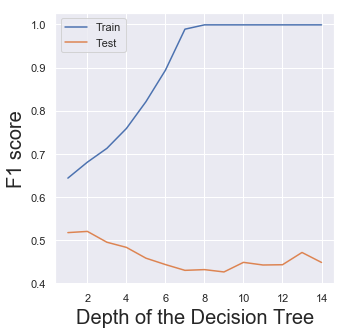

In [282]:
plt.figure(figsize=(5,5))
plt.plot(f1_score_dt_df)
plt.xlabel('Depth of the Decision Tree',fontsize=20)
plt.ylabel('F1 score',fontsize=20)
plt.legend(['Train','Test'])
plt.show()


### Learning Curve

In [292]:
estimator=AdaBoostClassifier(DecisionTreeClassifier(max_depth=4,max_features=0.8,random_state=3),
                                    n_estimators=50,random_state=8)
train_sizes, train_scores, valid_scores = learning_curve(estimator,
                            X_train_upsampled, y_train_upsampled,train_sizes=[0.2,0.4,0.6,0.8,1],cv=5,shuffle=True)

train_mean = train_scores.mean(axis=1)
valid_mean = valid_scores.mean(axis=1)

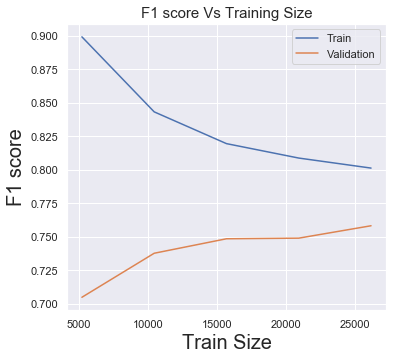

In [295]:
plt.plot(train_sizes, train_mean, label = 'Training error')
plt.plot(train_sizes, valid_mean, label = 'Validation error')
plt.xlabel('Train Size',fontsize=20)
plt.ylabel('F1 score',fontsize=20)
plt.legend(['Train','Validation'])
plt.title("F1 score Vs Training Size", fontsize=15)
plt.show()

### Test Dataset Predictions

In [251]:
classifier = AdaBoostClassifier(DecisionTreeClassifier(max_depth=4,
                                                       max_features=0.8,min_samples_split=4,random_state=3),
                                n_estimators=50,random_state=9)
classifier.fit(X_train_upsampled, y_train_upsampled)

pred_test = classifier.predict(X_test)
pred_train = classifier.predict(X_train_upsampled)
    
print(classification_report(y_test,pred_test))
pd.DataFrame(confusion_matrix(y_test,pred_test),index=['Actual 0','Actual 1'],columns=['Predicted 0','Predicted 1'])


              precision    recall  f1-score   support

           0       0.87      0.77      0.82      7000
           1       0.43      0.60      0.50      2000

    accuracy                           0.74      9000
   macro avg       0.65      0.69      0.66      9000
weighted avg       0.77      0.74      0.75      9000



,Predicted 0,Predicted 1
Actual 0,5416,1584
Actual 1,796,1204


### Feature Scaling

In [252]:
def feature_scaling(df_unscaled):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df_unscaled)
    scaled_data = pd.DataFrame(scaled_data, columns = df_unscaled.columns)
    return(scaled_data)

### Preparing the dataset for SVM

In [253]:
x=df.loc[:,df.columns != 'default_class']
x.iloc[:,0:20]=feature_scaling(x.iloc[:,0:20])
y=df['default_class']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3,random_state=1)

c:\users\aashe\appdata\local\programs\python\python37-32\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


### Undersampling the dataset to 60 to 40 ratio

In [263]:
xy_train = pd.concat([X_train, y_train], axis=1)
not_default = xy_train[xy_train['default_class']==0]
default = xy_train[xy_train['default_class']==1]

# upsample minority
default_undersampled_df = resample(not_default, replace=True, n_samples=7417, random_state=17) 
undersampled_df = pd.concat([default, default_undersampled_df])
undersampled_df['default_class'].value_counts()

X_train_undersampled = undersampled_df.loc[:,undersampled_df.columns != 'default_class']
y_train_undersampled = undersampled_df['default_class']


In [264]:
X_train_undersampled.head()

,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3
8447,-0.751350,-1.029047,0.014861,0.111736,0.138865,0.188746,0.234917,0.253137,-0.377734,-0.365381,...,0,1,0,0,0,0,0,0,1,0
4535,0.481833,0.164303,0.904712,-1.558876,-1.532192,-1.521944,-1.530046,-1.486041,-0.695642,-0.690983,...,0,1,0,0,0,0,0,0,1,0
27198,-1.059646,-0.052670,0.904712,-0.723570,-0.696663,1.899436,0.234917,0.253137,-0.695642,-0.322415,...,0,1,0,0,0,0,0,1,0,0
15632,-0.597202,-1.137534,0.904712,-0.723570,-0.696663,-0.666599,-0.647565,1.992316,-0.695642,-0.679181,...,0,1,0,0,0,0,0,0,1,0
17697,-0.828424,0.598248,1.794564,0.111736,0.138865,1.899436,0.234917,0.253137,0.071429,0.090820,...,0,1,0,0,0,0,0,1,0,0


### SVM Linear Kernel

In [256]:
from sklearn.model_selection import cross_val_score

cost_values = [0.01,0.1,0.5,1]
score_list = []
for cost in cost_values:
    clf = SVC(C=cost,kernel='linear',random_state=15)
    scores = cross_val_score(clf, X_train_undersampled, y_train_undersampled, cv=3,scoring='f1')
    print(cost, scores.mean())
    score_list.append(scores.mean())
    
cost_accuracy_df = pd.DataFrame({'F1 Score':score_list},index=cost_values)   

0.01 0.564915907304537
0.1 0.5668377531621563
0.5 0.5668377531621563
1 0.5666439782671948


### Plot for Penalty Vs F1 Score

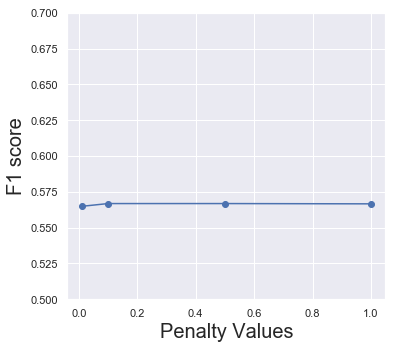

In [298]:
plt.plot(cost_accuracy_df,marker='o')
plt.xlabel('Penalty Values',fontsize=20)
plt.ylabel('F1 score',fontsize=20)
plt.ylim(0.5,0.7)
plt.show()

### Learning curves for Linear kernel SVM

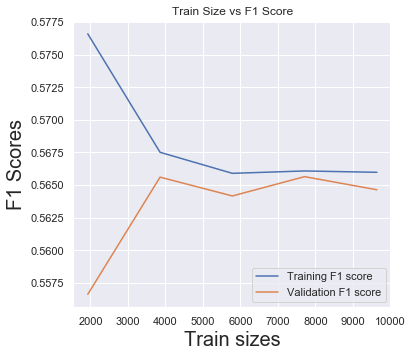

In [265]:
train_sizes, train_scores, valid_scores = learning_curve(SVC(C=0.1,kernel='linear'), 
    X_train_undersampled, y_train_undersampled,train_sizes=[0.2,0.4,0.6,0.8,1],scoring='f1',cv=5,
                                                         random_state=2,shuffle=True)

train_mean = train_scores.mean(axis=1)
valid_mean = valid_scores.mean(axis=1)

plt.plot(train_sizes, train_mean, label = 'Training F1 score')
plt.plot(train_sizes, valid_mean, label = 'Validation F1 score')
plt.xlabel("Train sizes",fontsize=20)
plt.ylabel("F1 Scores",fontsize=20)
plt.title("Train Size vs F1 Score")
plt.legend(loc="lower right")
plt.show()

### Test Dataset Predictions

In [266]:
f1_score_dic=dict()
svclassifier = SVC(C=0.1,kernel='linear')
svclassifier.fit(X_train_undersampled, y_train_undersampled)

pred_test = svclassifier.predict(X_test)
pred_train = svclassifier.predict(X_train_undersampled)

print("F1 score of training data is %.2f" %(f1_score(y_train_undersampled,pred_train)))
print("F1 Score of test data is %.2f" %(f1_score(y_test,pred_test)))
f1_score_dic['Linear'] = [f1_score(y_train_undersampled,pred_train),f1_score(y_test,pred_test)]
pd.DataFrame(confusion_matrix(y_test,pred_test),index=['Actual 0','Actual 1'],columns=['Predicted 0','Predicted 1'])

F1 score of training data is 0.57
F1 Score of test data is 0.50


,Predicted 0,Predicted 1
Actual 0,6425,575
Actual 1,1143,857


### SVM - Polynomial Kernel

In [267]:
svm_poly_df = pd.DataFrame()
cost_values = [0.01,0.1,0.5,1]
degree_values = [1,2,3,4]
for cost in cost_values:
    for degree in degree_values:
        clf = SVC(C=cost,kernel='poly',degree=degree,gamma='auto')
        scores = cross_val_score(clf, X_train_undersampled, y_train_undersampled, cv=3,scoring='f1')
        print(cost, scores.mean())
        values  =  [cost,degree,scores.mean()]
        values = pd.DataFrame(values).T
        svm_poly_df = pd.concat([svm_poly_df,values])
        
svm_poly_df.columns=['Cost','Degree','F1_Score']     

0.01 0.416323107084511
0.01 0.2510811303908134
0.01 0.12643253707962301
0.01 0.07688272048660326
0.1 0.5619650178659272
0.1 0.4755435276695397
0.1 0.3664320507089261
0.1 0.2834989720439464
0.5 0.5655808700203643
0.5 0.5681660669065707
0.5 0.4752874744859105
0.5 0.4069075284489203
1 0.5655384661057635
1 0.5760290156162898
1 0.5256485669882007
1 0.4516460842593748


### F1 Score Vs (Degree and Penalty)

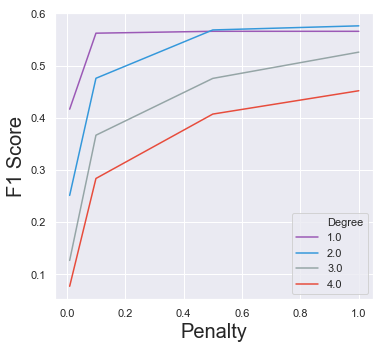

In [300]:
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c"]
ax = sns.lineplot(data=svm_poly_df, x='Cost', y='F1_Score',hue='Degree',palette=flatui)
ax.set(xlabel='Penalty', ylabel='F1 Score')
plt.rcParams["axes.labelsize"] = 20
plt.show()

### Learning curve - F1 Score Vs Train Size

In [270]:
train_sizes, train_scores, valid_scores = learning_curve(SVC(C=0.5,kernel='poly',degree=2,gamma='auto'), 
    X_train_undersampled, y_train_undersampled,train_sizes=[0.2,0.4,0.6,0.8,1],cv=5,scoring='f1',random_state=5,shuffle=True)

train_mean = train_scores.mean(axis=1)
valid_mean = valid_scores.mean(axis=1)

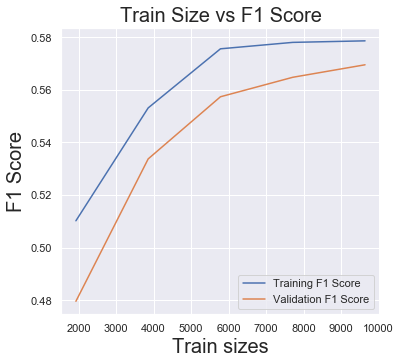

In [271]:
plt.plot(train_sizes, train_mean, label = 'Training F1 Score')
plt.plot(train_sizes, valid_mean, label = 'Validation F1 Score')
plt.xlabel("Train sizes",fontsize=20)
plt.ylabel("F1 Score",fontsize=20)
plt.title("Train Size vs F1 Score",fontsize=20)
plt.legend(loc="lower right")
plt.show()

### Test Dataset Predictions

In [35]:
f1_score_dic = dict()
svclassifier = SVC(C=0.5,kernel='poly',degree=2,gamma='auto')
svclassifier.fit(X_train_undersampled, y_train_undersampled)

pred_test = svclassifier.predict(X_test)
pred_train = svclassifier.predict(X_train_undersampled)

print("F1 Score of training data is %.2f" %(f1_score(y_train_undersampled,pred_train)))
print("F1 Score of test data is %.2f" %(f1_score(y_test,pred_test)))
f1_score_dic['Polynomial'] = [f1_score(y_train_undersampled,pred_train),f1_score(y_test,pred_test)]
pd.DataFrame(confusion_matrix(y_test,pred_test),index=['Actual 0','Actual 1'],columns=['Predicted 0','Predicted 1'])

F1 Score of training data is 0.61
F1 Score of test data is 0.52


,Predicted 0,Predicted 1
Actual 0,6277,723
Actual 1,1044,956


### Radial Basis Function

In [285]:
svm_radial_df = pd.DataFrame()
cost_values = [0.01,0.1,0.5,1]
gamma_values = [0.01,0.05,0.001,0.005]
for cost in cost_values:
    for gamma in gamma_values:
        clf = SVC(C=cost,kernel='rbf',gamma=gamma)
        scores = cross_val_score(clf, X_train_undersampled, y_train_undersampled, cv=3)
        print(cost, scores.mean())
        values  =  [cost,gamma,scores.mean()]
        values = pd.DataFrame(values).T
        svm_radial_df = pd.concat([svm_radial_df,values])
        
svm_radial_df.columns=['Cost','Gamma','F1_Score']     

0.01 0.6743552723352558
0.01 0.6960095508495464
0.01 0.6153654755296954
0.01 0.622666659151125
0.1 0.7165028846362897
0.1 0.729279223002001
0.1 0.6717834911173833
0.1 0.7094503539520775
0.5 0.7336765788609821
0.5 0.7389034110215297
0.5 0.7179131430080199
0.5 0.7279530189445954
1 0.7351700243691441
1 0.7417242994126584
1 0.7205684004216218
1 0.7316859926551271


### F1 Score Vs (Penalty and Gamma)

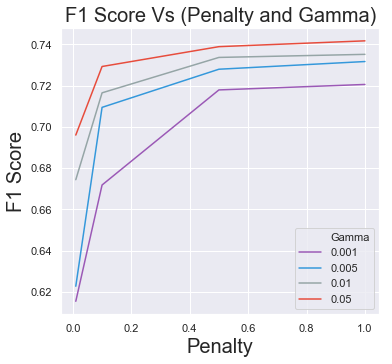

In [286]:
import seaborn as sns
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c"]
sns.lineplot(data=svm_radial_df, x='Cost', y='F1_Score',hue='Gamma',palette=flatui)
plt.xlabel("Penalty",fontsize=20)
plt.ylabel("F1 Score",fontsize=20)
plt.title("F1 Score Vs (Penalty and Gamma)",fontsize=20)
plt.legend(loc="lower right")
plt.show()

### Learning Curve - Train Size Vs F1 Score

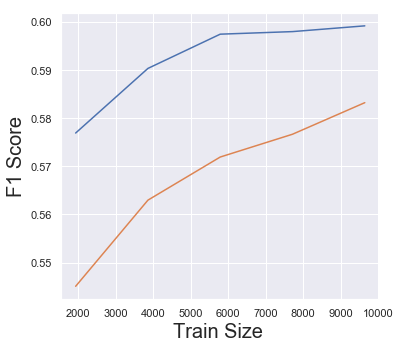

In [287]:
train_sizes, train_scores, valid_scores = learning_curve(SVC(C=0.5,kernel='rbf',gamma=0.05), 
    X_train_undersampled, y_train_undersampled,train_sizes=[0.2,0.4,0.6,0.8,1],cv=5,random_state=5,shuffle=True,scoring='f1')

train_mean = train_scores.mean(axis=1)
valid_mean = valid_scores.mean(axis=1)



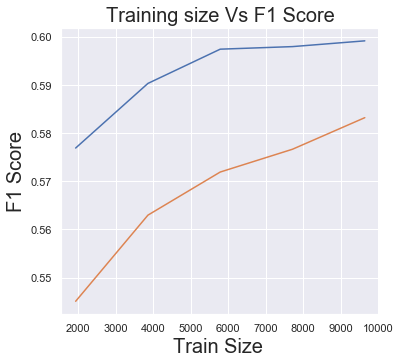

In [290]:
plt.plot(train_sizes, train_mean, label = 'Training F1 Score')
plt.plot(train_sizes, valid_mean, label = 'Validation F1 Score')
plt.xlabel("Train Size ",fontsize=20)
plt.ylabel("F1 Score",fontsize=20)
plt.title("Training size Vs F1 Score", fontsize=20)
plt.show()

### Test Results Predictions

In [296]:
f1_score_dic = dict()
svclassifier = SVC(C=0.5,kernel='rbf',gamma=0.05)
svclassifier.fit(X_train_undersampled, y_train_undersampled)

pred_test = svclassifier.predict(X_test)
pred_train = svclassifier.predict(X_train_undersampled)

print("F1 Score of training data is %.2f" %(f1_score(y_train_undersampled,pred_train)))
print("F1 Score of test data is %.2f" %(f1_score(y_test,pred_test)))
f1_score_dic['Radial'] = [f1_score(y_train_undersampled,pred_train),f1_score(y_test,pred_test)]
pd.DataFrame(confusion_matrix(y_test,pred_test),index=['Actual 0','Actual 1'],columns=['Predicted 0','Predicted 1'])

F1 Score of training data is 0.60
F1 Score of test data is 0.52


,Predicted 0,Predicted 1
Actual 0,6334,666
Actual 1,1073,927


In [50]:
print(classification_report(y_test,pred_test))

              precision    recall  f1-score   support

           0       0.86      0.89      0.87      7000
           1       0.55      0.49      0.52      2000

    accuracy                           0.80      9000
   macro avg       0.70      0.69      0.69      9000
weighted avg       0.79      0.80      0.79      9000

